### Compute LCMV inverse solution in volume source space
- Compute LCMV inverse solution on an auditory evoked dataset in a volume source space.

In [1]:
import mne
from mne.datasets import sample
from mne.beamformer import make_lcmv,apply_lcmv

In [2]:
data_path = sample.data_path()
subjects_dir = data_path + '/subjects'
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_raw-eve.fif'
fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-vol-7-fwd.fif'

In [3]:
# Get epochs
event_id, tmin, tmax = [1, 2], -0.2, 0.5

In [4]:
# Load datasets
raw = mne.io.read_raw_fif(raw_fname)
raw.info['bads'] = ['MEG 2443','EEG 053']
events = mne.read_events(event_fname)  # 通过events = mne.find_events(raw)也可以直接获取events

Opening raw data file /home/reallocing/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0


In [14]:
# Set up pick list: gradiometers and magnetometers, excluding bad channels
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=True, eog=True,
                       exclude='bads')

In [15]:
picks

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [16]:
# 将index 转换成对应的MEG通道名
raw.ch_names[1]

u'MEG 0112'

In [18]:
# pick the channels of interest
raw.load_data() # 因为在最开始读入数据时没有preload=True,所以使用此函数加载数据
raw.pick_channels([raw.ch_names[pick] for pick in picks])

Reading 0 ... 166799  =      0.000 ...   277.714 secs...


<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 315 x 166800 (277.7 sec), ~404.5 MB, data loaded>

In [19]:
# Re-normalize our empty-room projectors, so they are fine after subselection
raw.info.normalize_proj()

In [20]:
# Read epochs
proj = False
epochs = mne.Epochs(raw,events,event_id,tmin,tmax,baseline=(None,0),preload=True,proj=proj,reject=dict(grad=4000e-13,mag=4e-12,eog=150e-6))

145 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
Loading data for 145 events and 421 original time points ...
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on MAG : [u'MEG 1711']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on MAG : [u'MEG 1711']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  

In [21]:
# Evoked data are obtained by averaging epochs.
evoked = epochs.average()

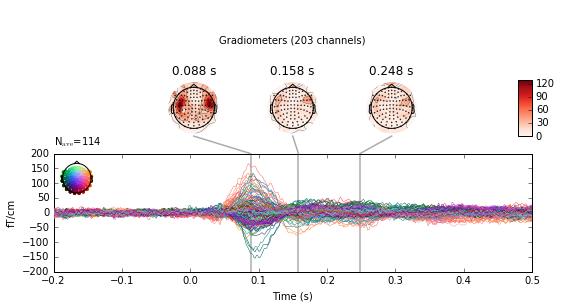

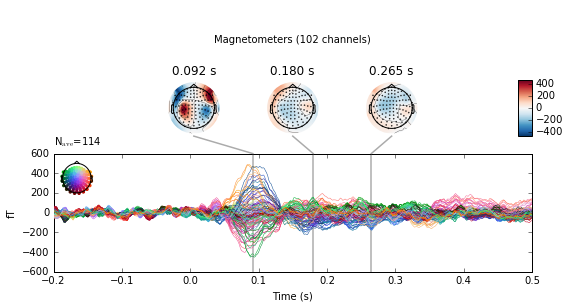

In [23]:
# Visualize sensor space data
evoked.plot_joint(ts_args=dict(time_unit='s'),
                  topomap_args=dict(time_unit='s'));

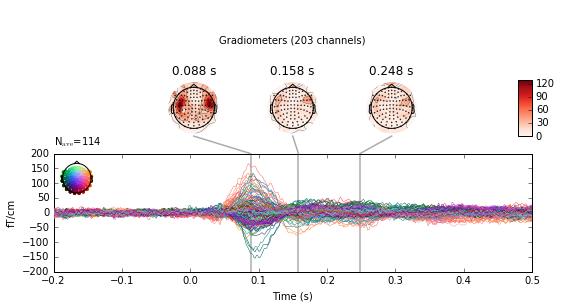

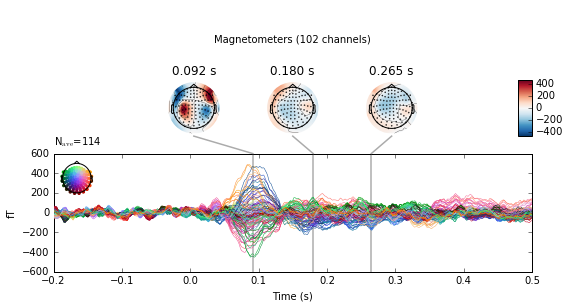

In [24]:
evoked.plot_joint();

#### Compute covariance matrices, fit and apply spatial filter.

In [26]:
# Read forward model
forward = mne.read_forward_solution(fname_fwd)

Reading forward solution from /home/reallocing/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-vol-7-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (3757 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [46]:
print(forward.viewkeys())
forward['info']

dict_keys(['info', 'sol_grad', 'nchan', 'src', 'source_nn', 'sol', 'source_rr', 'source_ori', 'surf_ori', 'coord_frame', '_orig_sol', 'mri_head_t', 'nsource', '_orig_source_ori'])


<Info | 12 non-empty fields
    bads : list | MEG 2443
    ch_names : list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 306 items (GRAD: 204, MAG: 102)
    command_line : unicode | 367 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    meas_file : unicode | 21 items
    mri_file : unicode | 29 items
    mri_head_t : Transform | 3 items
    mri_id : dict | 4 items
    nchan : int | 306
    working_dir : unicode | 79 items
    meas_id : NoneType
>

In [33]:
forward['src']

<SourceSpaces: [<volume, shape=(21, 26, 24), n_used=3757, coordinate_frame=head>]>

In [27]:
# Read regularized noise covariance and compute regularized data covariance
noise_cov = mne.compute_covariance(epochs, tmin=tmin, tmax=0, method='shrunk',
                                   rank=None)
data_cov = mne.compute_covariance(epochs, tmin=0.04, tmax=0.15,
                                  method='shrunk', rank=None)

# Compute weights of free orientation (vector) beamformer with weight
# normalization (neural activity index, NAI). Providing a noise covariance
# matrix enables whitening of the data and forward solution. Source orientation
# is optimized by setting pick_ori to 'max-power'.
# weight_norm can also be set to 'unit-noise-gain'. Source orientation can also
# be 'normal' (but only when using a surface-based source space) or None,
# which computes a vector beamfomer. Note, however, that not all combinations
# of orientation selection and weight normalization are implemented yet.
filters = make_lcmv(evoked.info, forward, data_cov, reg=0.05,
                    noise_cov=noise_cov, pick_ori='max-power',
                    weight_norm='nai', rank=None)
print(filters)

# You can save these with:
# filters.save('filters-lcmv.h5')

# Apply this spatial filter to the evoked data.
stc = apply_lcmv(evoked, filters, max_ori_out='signed')

    Created an SSP operator (subspace dimension = 3)
estimated rank (mag + grad): 302
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
Reducing data rank from 305 -> 302
Estimating covariance using SHRUNK
Done.
Number of samples used : 13794
[done]
    Created an SSP operator (subspace dimension = 3)
estimated rank (mag + grad): 302
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
Reducing data rank from 305 -> 302
Estimating covariance using SHRUNK
Done.
Number of samples used : 7638
[done]
    305 out of 306 channels remain after picking
    Created an SSP operator (subspace dimension = 3)
estimated rank (mag + grad): 302
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
<Beamformer  |  LCMV, subject unknown, 3757 vert, 305 ch, max-power ori, nai norm, rank 302>


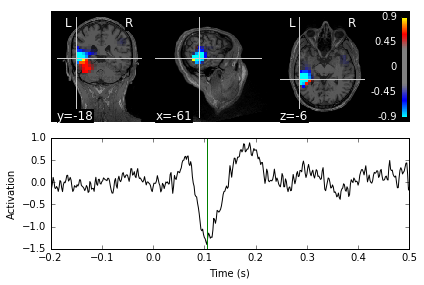

In [30]:
# You can save result in stc files with:
# stc.save('lcmv-vol')

# Plot source space activity
clim = dict(kind='value', pos_lims=[0.3, 0.6, 0.9])
stc.plot(src=forward['src'], subject='sample', subjects_dir=subjects_dir,
         clim=clim);

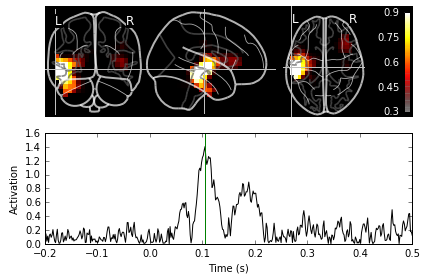

In [32]:
# Visualize the activity on a "glass brain"(shown here with absolute values)
clim = dict(kind='value', lims=[0.3, 0.6, 0.9])
abs(stc).plot(src=forward['src'], subject='sample', subjects_dir=subjects_dir,
              mode='glass_brain', clim=clim);